# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [10]:
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import mne
import matplotlib.colors as colors


In [11]:
packageroot = Path('../../').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

C:\Users\User\source-code\PyEEG
['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [12]:
tempfile.tempdir = str(packageroot / 'tmp')

In [13]:
tmpmet = core.DDFBinaryMetadata(packageroot / Path(r'notebooks\tests\test-data\A10 KO 12_13_2023\Cage 2 A10-0_Meta.csv'))
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Wed Dec 13 11:17:32 2023


['Intan Input (1)/PortC C-009',
 'Intan Input (1)/PortC C-010',
 'Intan Input (1)/PortC C-012',
 'Intan Input (1)/PortC C-014',
 'Intan Input (1)/PortC C-015',
 'Intan Input (1)/PortC C-016',
 'Intan Input (1)/PortC C-017',
 'Intan Input (1)/PortC C-019',
 'Intan Input (1)/PortC C-021',
 'Intan Input (1)/PortC C-022']

In [14]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:156: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [15]:
lan = core.LongRecordingAnalyzer(lrec, 10)

mags = []
phases = []

for i in range(lan.n_fragments // 100):
    if i == 20:
        break
    t = time.process_time()

    # lan.compute_nspike(i)
    # csd = lan.compute_csd(i)
    # plt.imshow(csd['alpha'])

    coh = lan.compute_cohere(i)
    plt.imshow(coh['gamma'])

    pcorr = lan.compute_pcorr(i)
    plt.imshow(pcorr)

    # cacoh = lan.compute_cacoh(i)
    # plt.imshow(cacoh[0])

    # cacoh = lan.compute_cacoh(i, freq_res=1, indices=([[0,1,2,3]], [[4,5,6,7]]))
    # mags.append(cacoh[0])
    # phases.append(cacoh[1])


    # fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    # ax[0].imshow(corr)
    # ax[1].imshow(pcorr)
    # plt.show()

# _, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=True)
# mags = np.stack(mags, axis=-1).mean(axis=-1)
# phases = np.stack(phases, axis=-1).mean(axis=-1)
# ax[0].semilogx(cacoh[2], mags.transpose())
# ax[1].semilogx(cacoh[2], phases.transpose(), c='C1')
# ax[0].set_title("Magnitude")
# ax[1].set_title("Phase")
# plt.show()


In [16]:
Path('./test-wars/A5').resolve()

WindowsPath('C:/Users/User/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [17]:
from dask.distributed import LocalCluster, Client

# Start a local cluster with 3 worker nodes
cluster = LocalCluster(n_workers=3, processes=True, threads_per_worker=1, memory_limit='1G')
# cluster = LocalCluster(n_workers=3, threads_per_worker=2, memory_limit='1G')
# cluster = LocalCluster(n_workers=3, threads_per_worker=3, memory_limit='1G')
client = Client(cluster)
client

c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63438 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:63438/status,
Dashboard: http://127.0.0.1:63438/status,Workers: 3
Total threads: 3,Total memory: 2.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63441,Workers: 3
Dashboard: http://127.0.0.1:63438/status,Total threads: 3
Started: Just now,Total memory: 2.79 GiB
Comm: tcp://127.0.0.1:63462,Total threads: 1
Dashboard: http://127.0.0.1:63463/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:63444,


In [18]:
# animal_ids = ['A5', 'A10', 'F22', 'G25']
animal_ids = ['A5']
# animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=1)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec(multiprocess_mode='serial')

    war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'], multiprocess_mode='dask')
    # war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    sar = ao.compute_spike_analysis(multiprocess_mode='dask')

C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:156: UserWarning: truncate = True. Only the first 1 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


In [19]:
war = visualization.WindowAnalysisResult.from_pickle_and_json(Path('./test-wars/A10').resolve())

Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


In [20]:
war.get_result(['all'], allow_missing=True).head(3)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdslope,cohere,pcorr,nspike,wavetemp
0,0,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.0,None,2023-12-13 11:15:31.640,True,"[45.94372, 79.14008, 35.041542, 72.76703, 49.0...","[2109.172, 6243.4824, 1227.7904, 5292.8623, 23...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2147.5413, 5670.2437, 1340.4015, 4999.6924, 2...","{'delta': [1880.651, 2076.6309, 1154.8229, 248...","[(-2.516556545726344, 3.3398549980989127), (-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
1,1,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.0,None,2023-12-13 11:15:35.640,True,"[17.386616, 104.45952, 17.702452, 87.68795, 40...","[300.913, 10911.759, 312.7414, 7676.2407, 1618...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[207.7021, 10274.228, 222.3077, 7361.228, 1451...","{'delta': [113.76094, 4511.131, 144.73114, 301...","[(-1.941827861405488, 2.3862405602332184), (-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
2,2,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.0,None,2023-12-13 11:15:39.640,True,"[21.215885, 101.42181, 17.910995, 85.188, 48.4...","[448.86877, 10286.33, 319.65482, 7256.164, 234...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[350.06873, 9339.712, 208.8498, 6142.2837, 221...","{'delta': [217.75006, 3193.6636, 138.69931, 22...","[(-2.025236183682037, 2.537386099791813), (-1....","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN


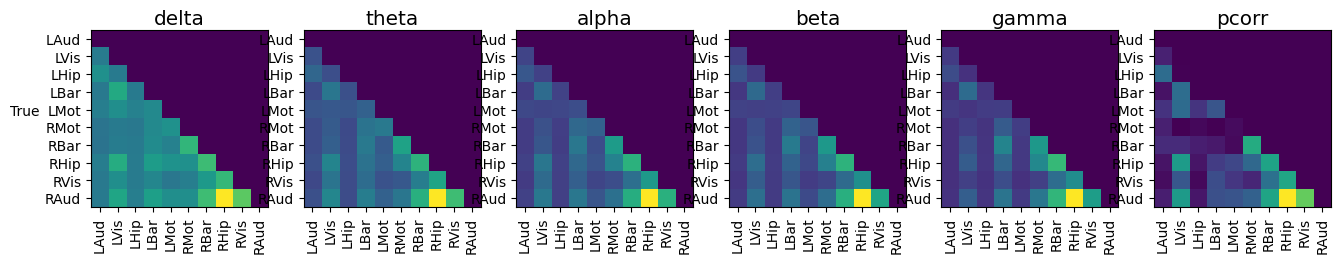

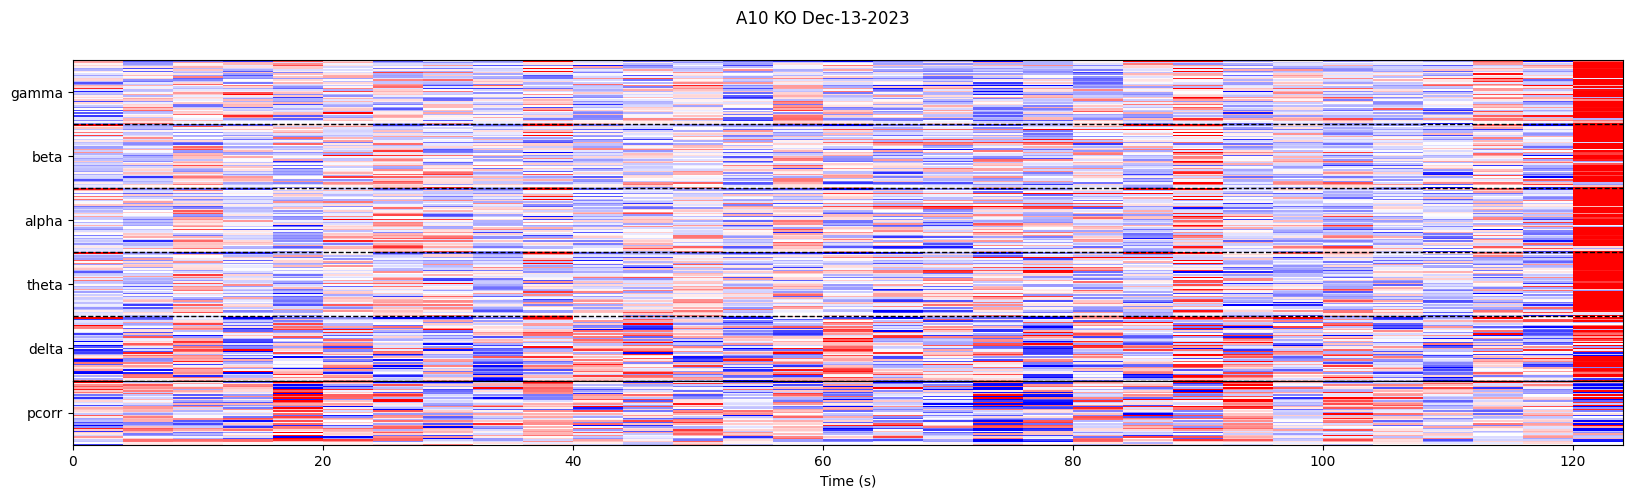

C:\Users\User\source-code\PyEEG\pythoneeg\visualization\plotting\animal.py:331: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


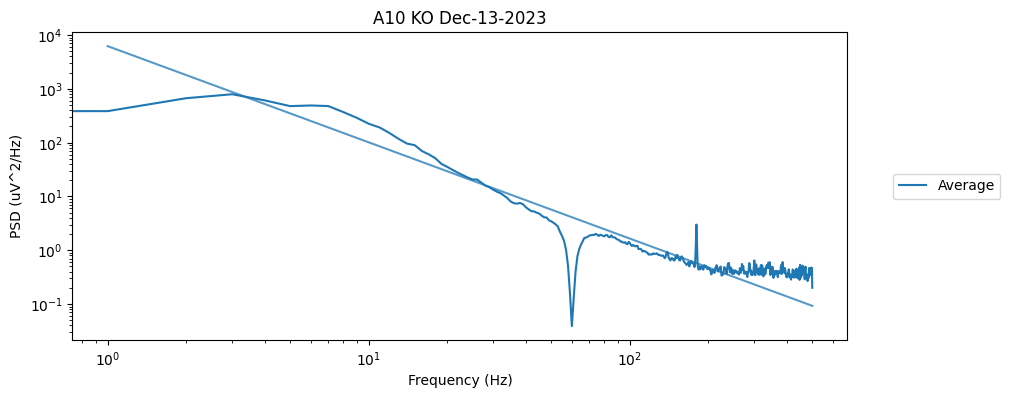

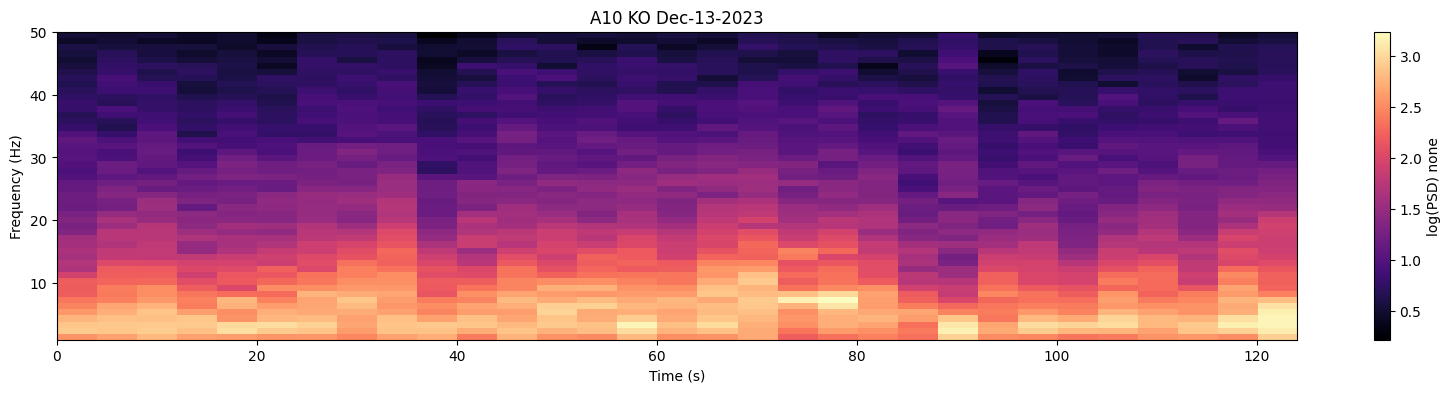

In [21]:
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-014', 'Intan Input (1)/PortD D-015', 'Intan Input (1)/PortD D-016', 'Intan Input (1)/PortD D-017', 'Intan Input (1)/PortD D-019', 'Intan Input (1)/PortD D-021', 'Intan Input (1)/PortD D-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='animal', ylabel='rms'>,
 None)

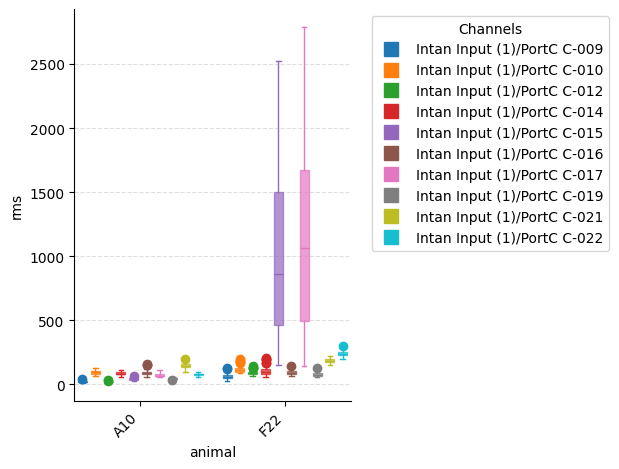

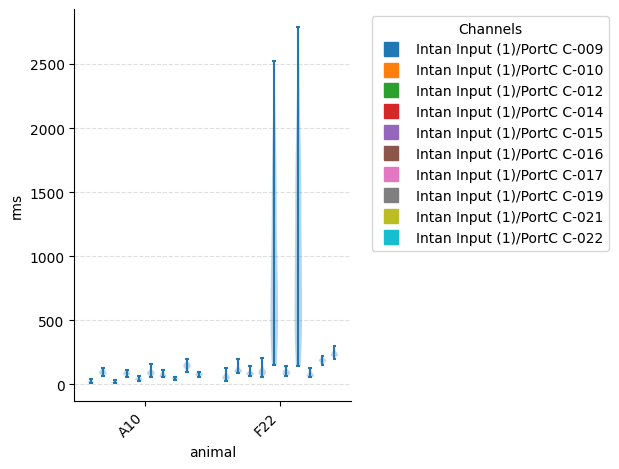

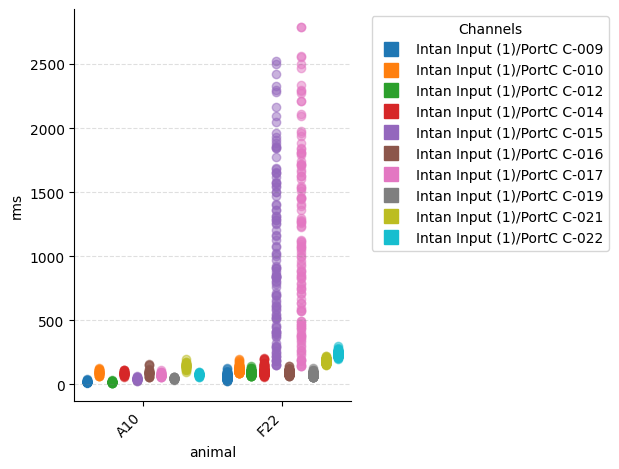

In [22]:
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    wars.append(visualization.WindowAnalysisResult.from_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve()))
ep = visualization.ExperimentPlotter(wars)
ep.plot_boxplot('rms')
ep.plot_violin('rms')
ep.plot_scatter('rms')

In [23]:
# sar[0].result
# visualization.SpikeAnalysisResult.convert_sas_to_mne(sar[0].result)

In [24]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logger = logging.getLogger()


In [25]:
def analyze_peri_spike_tfr(mne_obj, tmin=-10, tmax=10, l_freq=0.1, h_freq=100):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    events, event_dict = mne.events_from_annotations(raw=raw)
    
    # Common parameters for epoch creation
    epoch_params = {
        'raw': raw,
        'preload': True,
        'baseline': None,
        'event_repeated': 'drop'
    }
    
    # Process each spike type separately
    for unit_id in event_dict.keys():
        print(f"Processing unit: {unit_id}")
        
        # Create spike-centered epochs
        epochs_spike = mne.Epochs(
            **epoch_params,
            event_id={unit_id: event_dict[unit_id]},
            tmin=tmin,
            tmax=tmax
        )
        epochs_spike.filter(l_freq=l_freq, h_freq=h_freq)
        fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
        plt.show()
        
        # Create baseline epochs from whole recording
        epochs_baseline = mne.make_fixed_length_epochs(
            raw, 
            duration=tmax-tmin,
            preload=True
        )
        epochs_baseline.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Ensure we have comparable numbers of epochs
        n_epochs = min(len(epochs_spike), len(epochs_baseline))
        if n_epochs < 1:
            print(f"No valid epochs for unit {unit_id}")
            continue
            
        epochs_spike = epochs_spike[:n_epochs]
        epochs_baseline = epochs_baseline[:n_epochs]
        
        # Compute time-frequency representation
        tfr_params = dict(
            freqs=np.arange(l_freq, h_freq, 1),
            n_cycles=np.arange(l_freq, h_freq, 1) * 2,
            method='multitaper',
            use_fft=True,
            average=True
        )
        
        print("Computing TFR...")
        tfr_spike = epochs_spike.compute_tfr(**tfr_params)
        tfr_baseline = epochs_baseline.compute_tfr(**tfr_params)
        
        # Plot the results
        plot_tfr_ratio(tfr_spike, tfr_baseline)
        
        return tfr_spike, tfr_baseline

def plot_tfr_ratio(tfr_spike, tfr_baseline):
    """Plot the ratio between spike and baseline TFR."""
    pow_baseline = np.mean(tfr_baseline.get_data(), axis=(0, 2))
    pow_baseline = pow_baseline[:, np.newaxis]
    pow_spike, plot_t, plot_f = tfr_spike.get_data(return_times=True, return_freqs=True)
    pow_spike = np.mean(pow_spike, axis=0)
    pow_ratio = pow_spike / pow_baseline
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    im = ax.imshow(pow_ratio, aspect='auto',
                   extent=[plot_t[0], plot_t[-1], plot_f[0], plot_f[-1]],
                   origin='lower',
                   cmap=plt.cm.RdBu_r,
                   norm=colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=10))
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.axvline(0, color='black', linestyle='--')
    plt.colorbar(im, ax=ax, label='Power Ratio (spike/baseline)')
    plt.show()


In [26]:
# Example usage:
mne_obj: mne.io.RawArray = visualization.SpikeAnalysisResult.convert_sas_to_mne(sar[0].result)

Creating RawArray with float64 data, n_channels=10, n_times=466320
    Range : 0 ... 466319 =      0.000 ...   466.319 secs
Ready.


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx_1'), np.str_('Intan Input (1)/PortB L Barrel_1'), np.str_('Intan Input (1)/PortB L Hipp_1'), np.str_('Intan Input (1)/PortB L Motor_1'), np.str_('Intan Input (1)/PortB L Vis Ctx_1'), np.str_('Intan Input (1)/PortB R Aud Ctx_1'), np.str_('Intan Input (1)/PortB R Barrel_1'), np.str_('Intan Input (1)/PortB R Hipp_1'), np.str_('Intan Input (1)/PortB R Motor_1'), np.str_('Intan Input (1)/PortB R Vis Ctx_1')]


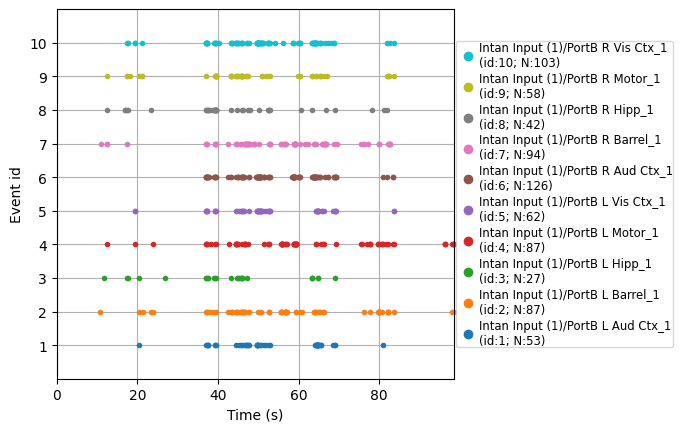

In [27]:
events = mne.events_from_annotations(raw=mne_obj)

fig = mne.viz.plot_events(events[0], sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=events[1])


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx_1'), np.str_('Intan Input (1)/PortB L Barrel_1'), np.str_('Intan Input (1)/PortB L Hipp_1'), np.str_('Intan Input (1)/PortB L Motor_1'), np.str_('Intan Input (1)/PortB L Vis Ctx_1'), np.str_('Intan Input (1)/PortB R Aud Ctx_1'), np.str_('Intan Input (1)/PortB R Barrel_1'), np.str_('Intan Input (1)/PortB R Hipp_1'), np.str_('Intan Input (1)/PortB R Motor_1'), np.str_('Intan Input (1)/PortB R Vis Ctx_1')]
Processing unit: Intan Input (1)/PortB L Aud Ctx_1
Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx_1'), np.str_('Intan Input (1)/PortB L Barrel_1'), np.str_('Intan Input (1)/PortB L Hipp_1'), np.str_('Intan Input (1)/PortB L Motor_1'), np.str_('Intan Input (1)/PortB L Vis Ctx_1'), np.str_('Intan Input (1)/PortB R Aud Ctx_1'), np.str_('Intan Input (1)/PortB R Barrel_1'), np.str_('Intan Input (1)/PortB R Hipp_1'), np.str_('Intan Input (1)/PortB R Motor_1'), np.str_('Intan Input (1)/PortB R Vi

C:\Users\User\source-code\PyEEG\tmp\ipykernel_2756\2488369046.py:40: RuntimeWarning: filter_length (33001) is longer than the signal (2001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_spike.filter(l_freq=l_freq, h_freq=h_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s


Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s


53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated


C:\Users\User\source-code\PyEEG\tmp\ipykernel_2756\2488369046.py:41: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
C:\Users\User\source-code\PyEEG\tmp\ipykernel_2756\2488369046.py:41: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
C:\Users\User\source-code\PyEEG\tmp\ipykernel_2756\2488369046.py:41: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
C:\Users\User\source-code\PyEEG\tmp\ipykernel_2756\2488369046.py:41: RuntimeWarning: Cannot find channel coor

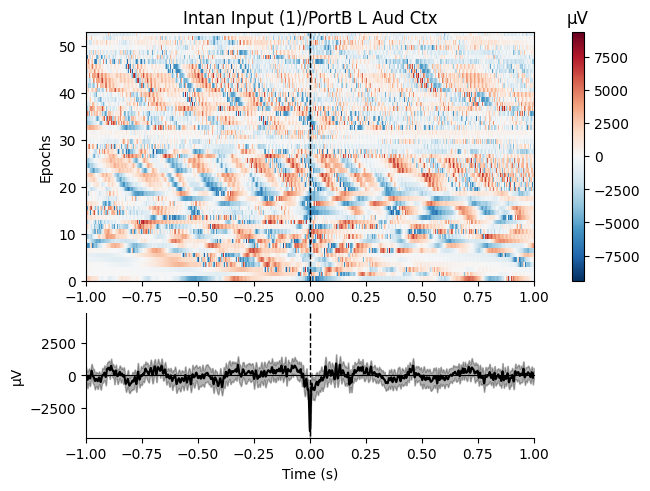

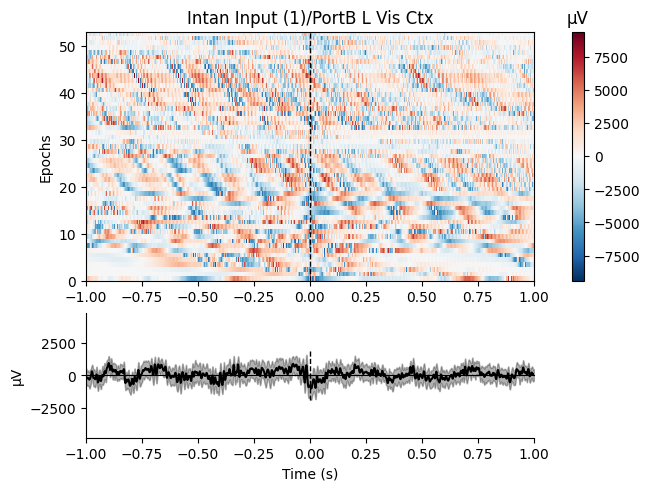

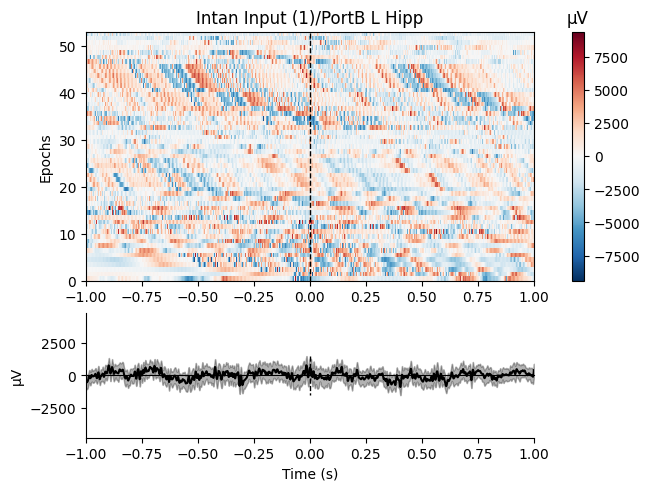

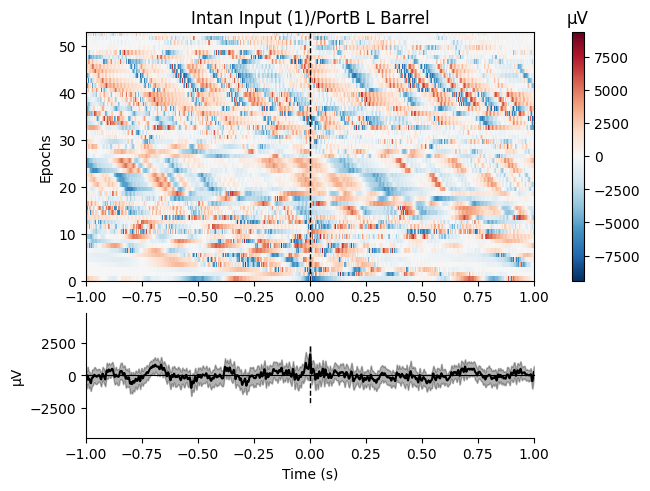

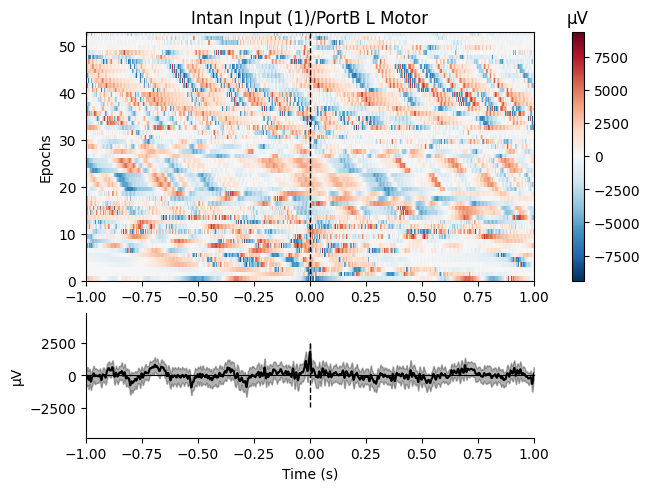

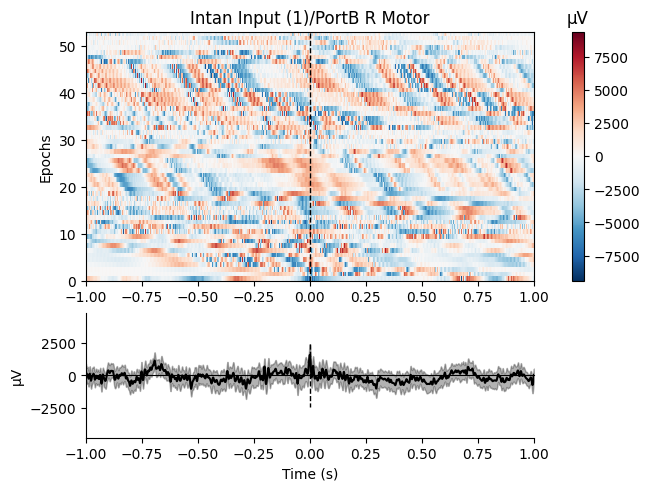

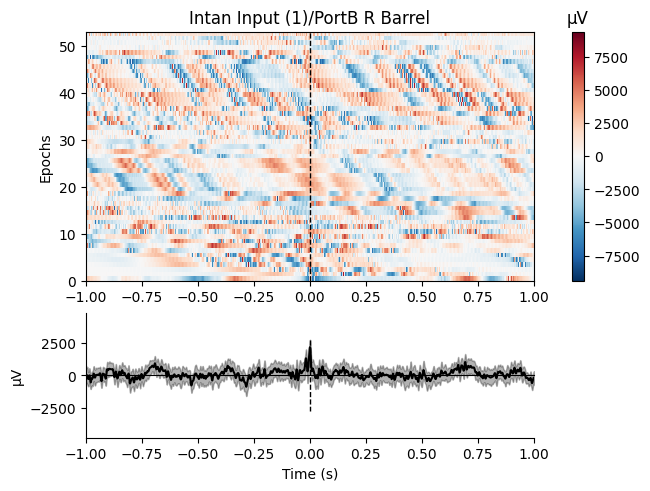

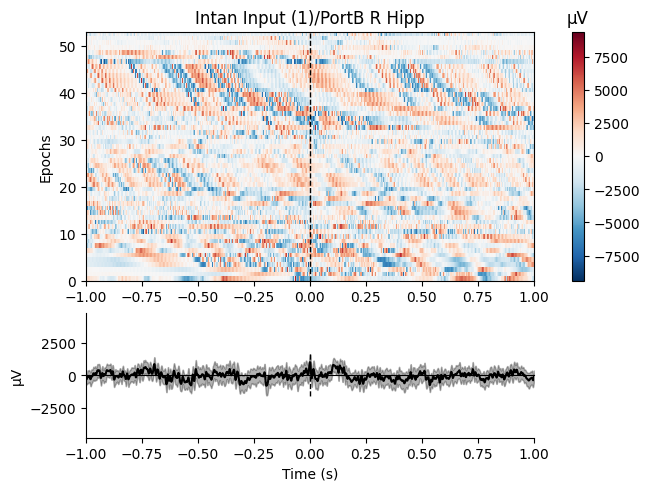

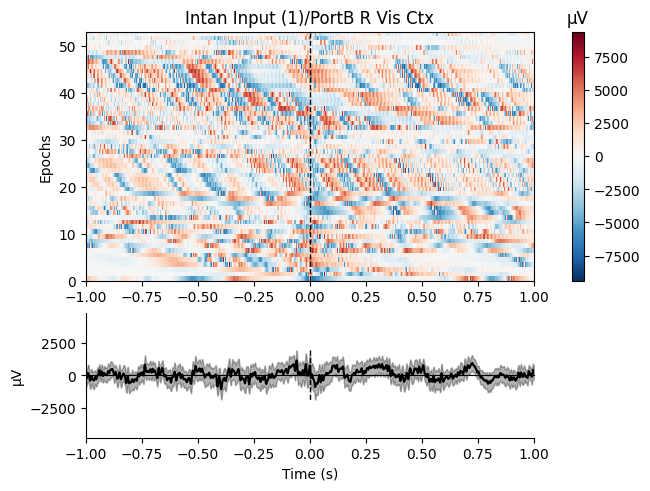

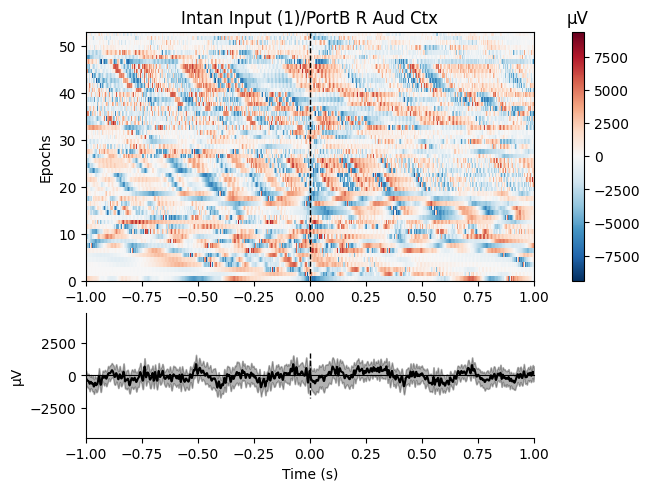

Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 233 events and 2000 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33001 samples (33.001 s)



C:\Users\User\source-code\PyEEG\tmp\ipykernel_2756\2488369046.py:50: RuntimeWarning: filter_length (33001) is longer than the signal (2000), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_baseline.filter(l_freq=l_freq, h_freq=h_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    2.1s


Computing TFR...


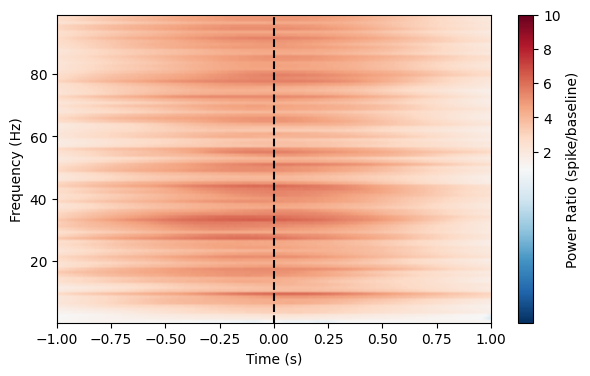

In [28]:
tfr_spike, tfr_baseline = analyze_peri_spike_tfr(mne_obj, tmin=-1, tmax=1)